# Fitness response to affinity increase

Phylodynamic inference of affinity-fitness response functions is an ongoing [project](https://github.com/matsengrp/gcdyn), but we could consider cruder approximations for the replay paper, without requiring any novel statistical methods.
In particular, we can directly model the dynamics of the affinity distribution in the 10x sequencing from whole lymph nodes, abstracting away the sequence- and tree-level detail in the model.

The downside is that we would be completely ignoring our GC-level data for this calculation.

## Model

Assume that both the population size and population-scaled mutation rate in the lymph node are large, so we use a continuum approximation to deterministically model the distribution $p(x,t)$ of affinity $x$ at time $t$.
We interpret the 10x affinity timecourse as sampling from $p(x,t)$.

Write the mean affinity at time $t$
$$
\bar x(t) := \int_{-\infty}^\infty x \ p(x,t)\mathrm{d}x.
$$

The Malthusian fitness of affinity $x$ in a population with mean affinity $\bar x$ is modeled via a linear response to the excess affinity $x - \bar x(t)$ and a cutoff (diminishing returns) with increasing mean:
$$
f(x, \bar{x}) = \alpha(x - \bar{x})g(\bar{x}; x_c, \beta),
$$
where $\alpha>0$ is the linear response coefficient, and $g:\mathbb{R}\to[0, 1]$ is a monotone decreasing cutoff function with location and scale parameters $x_c$ and $\beta$, respectively.
Notice that the mean fitness $\int_{-\infty}^\infty f(x,\bar x)p(x,t)\mathrm{d}x \propto \int_{-\infty}^\infty (x-\bar x)p(x,t)\mathrm{d}x = 0$ vanishes identically, so the population size is at a steady state.

We have the forward equation
$$
\frac{\partial}{\partial t}p(x,t) = \underbrace{f(x,\bar x(t))\,p(x,t)}_{\text{Malthusian growth}} + \underbrace{\mu\left(\int_{-\infty}^\infty q(y)p(x-y,t)\mathrm{d}y-p(x,t)\right)}_{\text{net mutation to state } x},
$$
where the mutation rate is $\mu\ge 0$, and $q$ is the distribution of affinity effects of mutations (which we have a good handle on from DMS data).
To avoid mathematical pathologies with the mean-field dependence, we should stipulate that the support of $q$ is bounded above (and our DMS effects satisfy this anyway).

Vaccination occurs at $t=0$, and we assume the lymph node is initially populated with unmutated adoptively transferred B-cells.
So we have the initial condition $p(x,0)=\delta(x)$.

### Discretizing phenotype space

We discretize the continuous phenotype space $\mathbb{R}$ above into $n$ ordered affinity states $\mathbf{x}\in\mathbb{R}^n$.
The continuous affinity distribution $p(x,t)$ is approximated by a discrete distribution $\mathbf{p}(t)\in\mathbb{R}^n$, satisfying the initial value problem
$$
\begin{align*}
\dot{\mathbf{p}} &= \mathbf{f}(\mathbf{x}, \bar{x}(t))\circ\mathbf{p} + \mu\,Q^\intercal\,\mathbf{p}\\
\mathbf{p}(0)&=\mathbf{e}_i,
\end{align*}
$$
where $\mu\,Q\in\mathbb{R}^{n\times n}$ is the mutation transition rate matrix, and $\mathbf{e}_i$ is the $i$-th standard basis vector (indicating initial state $i$).

## Numerical solver

Our data includes the relaxation phase, so we solve numerically without a traveling-wave anstatz.

In [28]:
import diffrax as dx
import jax
import jax.numpy as jnp
import equinox as eqx
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from jax.config import config
config.update("jax_enable_x64", True)

import jaxopt

Phenotype discretization

In [29]:
n = 2001
x = np.linspace(-10, 10, n)
assert x[n // 2] == 0

Right-hand side function for ODE system

In [30]:
@jax.jit
def g(x_mean, β, xc):
    # return α * (x - x_mean) / (1 + jnp.exp(β * (x_mean - xc)))
    # x_mean - xc = jnp.log(jnp.e-1) / β
    loc = xc - jnp.log(jnp.e-1) / β
    return (1 - jnp.log1p(jnp.exp(β * (x_mean - loc))))

@jax.jit
def f(x, x_mean, α, β, xc):
    return α * (x - x_mean) * g(x_mean, β, xc)

@jax.jit
def term(t, p, args):
    x, α, β, xc, μ, Q = args
    x_mean = x @ p
    return f(x, x_mean, α, β, xc) * p + μ * p @ Q


Define parameters

In [31]:
α = 0.1
β = 10.0
xc = 0.5
μ = 0.5

Plot cutoff function

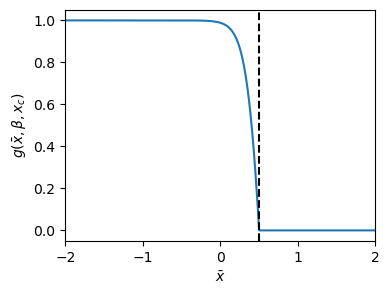

In [32]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(x, np.clip(g(x, β, xc), 0, None))
ax.axvline(xc, color="k", ls="--")
ax.set_xlim(-2, 2)
ax.set_xlabel(r"$\bar{x}$")
ax.set_ylabel(r"$g(\bar{x}, \beta, x_c)$")
plt.show()


We fix a mutation kernel that resembles the distribution of affinity effects in the DMS data.

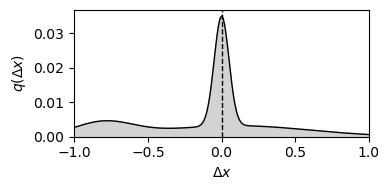

In [33]:
Q = jnp.zeros((n, n))
q = np.zeros(n)
q_means = [0, 0.1, -0.8]
q_stds = [0.05, 0.5, 0.2]
q_weights = [2.0, 2.0, 1.0]
# q_means = [-0.01]
# q_stds = [0.05]
# q_weights = [1.0]
for q_weight, q_mean, q_std in zip(q_weights, q_means, q_stds):
    Q += q_weight * jax.scipy.stats.norm.pdf(x[None, :], x[:, None] + q_mean, q_std)
    q += q_weight * jax.scipy.stats.norm.pdf(x, q_mean, q_std)
Q /= Q.sum(1, keepdims=True)
Q = Q.at[jnp.diag_indices(len(Q))].set(-Q.sum(1) + jnp.diag(Q))
q /= q.sum()
assert np.allclose(Q.sum(1), 0)
assert np.allclose(q.sum(), 1)

plt.figure(figsize=(4, 2))
plt.fill_between(x, q, color='lightgrey')
plt.plot(x, q, lw=1, color='k')
plt.axvline(0, color='k', ls='--', lw=1)
plt.xlim(-1, 1)
plt.ylim(0, None)
plt.xlabel("$\Delta x$")
plt.ylabel("$q(\Delta x)$")
plt.tight_layout()
plt.show()

Initial condition $\mathbf{p}(0) = \mathbf{e}_i$, where $x_i = 0$.

In [34]:
p0 = jnp.zeros(n)
p0 = p0.at[n // 2].set(1.0)

Solve

In [35]:
t = np.linspace(0, 20, 81)
m = len(t)

ode_term = dx.ODETerm(term)
rtol = 1e-6
atol = 1e-6
max_steps = 10000
dt0 = (t.max() - t.min()) / 1000
solver = dx.Bosh3()
stepsize_controller = dx.PIDController(rtol=rtol, atol=atol)

@jax.jit
def p_solve(x, t, α, β, xc, μ, Q):
    sol = dx.diffeqsolve(ode_term, solver, args=(x, α, β, xc, μ, Q),
                         t0=0, t1=t[-1], dt0=dt0,
                         y0=p0,
                         saveat=dx.SaveAt(ts=t),
                         stepsize_controller=stepsize_controller,
                         max_steps=max_steps,
                         )
    return sol.ys.T

p = p_solve(x, t, α, β, xc, μ, Q)
p.shape

(2001, 81)

Plot limit parameters

In [36]:
p_max = 0.02
x_min = -3
x_max = 3

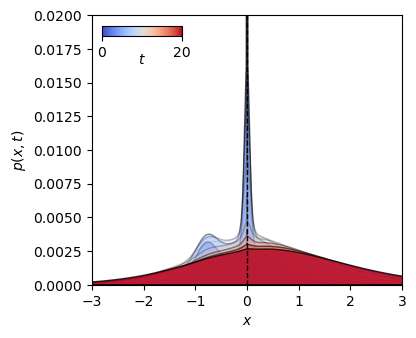

In [37]:
fig, ax = plt.subplots(figsize=(4, 3.5))
plt.axvline(0, color='k', ls='--', lw=1)
colors = plt.cm.coolwarm(t / t[-1])
for j in range(0, len(t), 10):
    ax.fill_between(x, p[:, j],
             edgecolor="k",
             facecolor=colors[j],
             alpha=float(0.8 * (0.1 + 0.9 * 2 * abs(t[j] / t[-1] - 1 / 2))),
             )
plt.xlim(x_min, x_max)
plt.ylim(0, p_max)
plt.xlabel('$x$')
plt.ylabel('$p(x,t)$')
cbar = plt.colorbar(
             mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=t[-1]),
                                   cmap="coolwarm"),
             orientation='horizontal',
             cax=fig.add_axes([.15, 0.82, 0.2, 0.03]),
)
cbar.set_label(label='$t$', size=10, labelpad=-5)
plt.show()

Quartiles of the affinity distribution over time

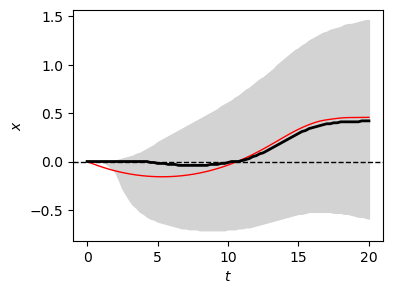

In [38]:
# find the indices of the quartiles
q1 = np.array([x[np.cumsum(p[:, j], axis=0).searchsorted(0.25, side="right")] for j in range(len(t))])
q2 = np.array([x[np.cumsum(p[:, j], axis=0).searchsorted(0.50, side="right")] for j in range(len(t))])
q3 = np.array([x[np.cumsum(p[:, j], axis=0).searchsorted(0.75, side="right")] for j in range(len(t))])

fig, ax = plt.subplots(figsize=(4, 3))
plt.axhline(0, color="k", ls="--", lw=1)
ax.fill_between(t, q1, q3, color="lightgrey")
ax.plot(t, x @ p, "r-", lw=1)
# ax.plot(t, q1, "k--", lw=1)
# ax.plot(t, q3, "k--", lw=1)
ax.plot(t, q2, "k", lw=2)
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$x$")
# ax.set_ylim(x_moment_min, x_moment_max)
plt.show()

In [39]:
assert np.allclose(p.sum(0), 1), p.sum(0)

Animation

In [65]:
fps = 24

fig, ax = plt.subplots(#2, 1,
                       #sharex=False, sharey=False,
                       figsize=(6, 4),
                    #    height_ratios=(2, 1),
                       )

def init():
    # ax[0].set_xlabel(r"x")
    ax.set_xlabel(r"$\Delta$ affinity")
    # ax[0].set_ylabel(r"$p(x, t)$")
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(0, p_max)
    ax.axvline(0, color='k', ls='--', lw=1)
    ax.axvline(xc, color='k', ls='--', lw=0.5)

    # ax[1].set_xlim(0, t[-1])
    # ax[1].set_xlabel(r"$t$")
    # # ax[1].set_ylabel(r"$x$")
    # ax[1].set_ylabel(r"$\Delta$ affinity")
    # ax[1].set_ylim(x_moment_min, x_moment_max)

    fig.tight_layout()

def update(frame):
    # ax[0].clear()
    # remove the previous frame
    for c in ax.collections:
        c.remove()
    ax.fill_between(x, p[:, frame],
                       color="lightgrey",
                       facecolor=colors[frame],
                       lw=1,
                       edgecolor="k",
                       animated=True)
    ax.set_title(rf"$t = {t[frame]:.1f}$")

    # # ax[1].clear()  
    # ax[1].plot(t[:(frame + 1)], x_mean[:(frame + 1)], "C0", label=r"mean" if frame == 0 else None, animated=True)
    # ax[1].plot(t[:(frame + 1)], x_std[:(frame + 1)], "C1", label=r"std" if frame == 0 else None, animated=True)
    # ax[1].legend(loc="upper left")

ani = animation.FuncAnimation(fig, update, init_func=init, frames=len(t), interval=1000/fps)

# save
ani.save("output/affinity-fitness-response/affinity-fitness-response.gif", fps=fps, dpi=200)

html_video = HTML(ani.to_jshtml())
plt.close()
html_video

MovieWriter ffmpeg unavailable; using Pillow instead.
/var/folders/0w/l84hyz3n6ns582pxy6tkt8y80000gn/T/ipykernel_36365/3500415654.py:24: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


## Sampling

The timecourse data $\mathcal{D}$ consists of a set of sampling times and a sample of affinities at each such time, so
$\mathcal{D}\subset\mathbb{R}_+\times2^\mathbb{R}$.
The sample size of a sample $(t, \mathcal{X})\in\mathcal{D}$ is $\left|\mathcal{X}\right|$.

In [41]:
sampling_times = np.array([5, 8, 11, 14, 17, 20], dtype=np.float64)
sample_sizes = np.array([100, 1000, 1000, 1000, 1000, 1000])
n_samples = len(sampling_times)

In [42]:
p_samples = p_solve(x, sampling_times, α, β, xc, μ, Q)

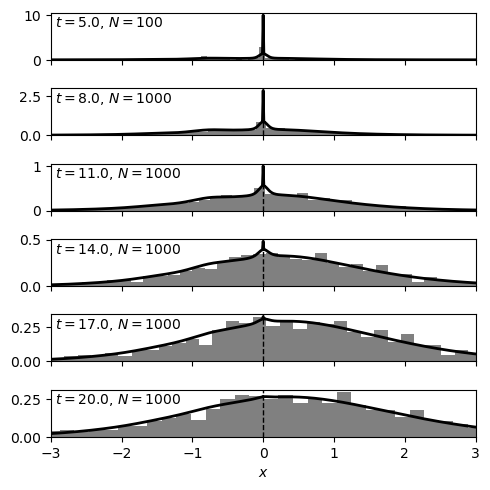

In [43]:
key = jax.random.PRNGKey(0)

fig, axes = plt.subplots(n_samples, 1, figsize=(5, 5), sharex=True)

samples = []
for sampling_time, sample_size, p_sample, ax in zip(sampling_times, sample_sizes, p_samples.T, axes):
    samples.append([])
    for sample_idx in jax.random.choice(key, n, shape=(sample_size,), p=p_sample):
        samples[-1].append(sample_idx)
    samples[-1] = np.array(samples[-1])
    ax.axvline(0, color='k', ls='--', lw=1)
    ax.hist(x[samples[-1]], bins=50, density=True, color='grey')
    ax.plot(x, p_sample / (x[1] - x[0]), lw=2, color='k')
    ax.annotate(rf"$t={sampling_time}$, $N={sample_size}$", xy=(0.01, 0.7), xycoords="axes fraction")
ax.set_xlabel(r"$x$")
ax.set_xlim(x_min, x_max)
plt.tight_layout()
plt.show()

## Maximum likelihood estimation

The log-likelihood of $(\alpha, \mu)$ given the timecourse data is
$$
\ell(\alpha,\mu) = \sum_{(t, \mathcal{X})\in\mathcal{D}}\,\sum_{x\in\mathcal{X}}\log p(x, t).
$$
Note that the parameters $\alpha$ and $\mu$ enter the likelihood via the PDE for $p(x,t)$.
In discrete form, this is
$$
\ell(\alpha,\mu) = \sum_{(t, \mathcal{X})\in\mathcal{D}}\,\sum_{i=1}^n\,c_i(\mathcal{X})\log p_i(t),
$$
where the binning function $\mathbf{c}:2^\mathbb{R}\to\mathbb{N}_0^n$ maps an affinity data set to a vector of affinity bin counts (with bins defined by the previous affinity discretization $\mathbf{x}$), and $p_i(t)$ is the $i$-th component of $\mathbf{p}(t)$.

In [44]:
affinity_bin_counts = np.zeros((n, n_samples))
for i, sample in enumerate(samples):
    for j in samples[i]:
        k = np.searchsorted(x, x[j])
        affinity_bin_counts[k, i] += 1

assert all(affinity_bin_counts.sum(0) == sample_sizes)

affinity_bin_counts.shape

(2001, 6)

In [45]:
@eqx.filter_jit
def neg_log_likelihood(params):
    α, β, xc, μ = params
    return -(affinity_bin_counts * jnp.log(p_solve(x, sampling_times, α, β, xc, μ, Q))).sum()

@eqx.filter_jit
@eqx.filter_value_and_grad
def neg_log_likelihood_value_and_grad(params):
    return neg_log_likelihood(params)

To maximize the likelihood, we use use L-BFGS-B, with backpropagation through the PDE solver.

In [52]:
params_true = jnp.array([α, β, xc, μ])
params0 = jnp.array([0.6 * α, 1.1 * β, 0.6 * xc, 0.9 * μ])
lower_bounds = 0.5 * params_true
upper_bounds = 1.5 * params_true
bounds=(lower_bounds, upper_bounds)

opt = jaxopt.LBFGSB(neg_log_likelihood_value_and_grad,
                    value_and_grad=True,
                    jit=False,
                    implicit_diff=False,
                    verbose=True,
                    maxiter=10, tol=1e-2,
                    # maxls=30, max_stepsize=1e2, min_stepsize=1e-8, increase_factor=2.0,
                    )

params, state = opt.run(params0, bounds)

error: 0.3361181459931125
error: 0.2995041912627882
error: 0.6263503888000699
error: 0.31395650277221265
error: 0.3063837451449882
error: 0.25804617195154844
error: 0.24312158453946559
error: 0.25685999462081643
error: 0.12890074068099805


Plot likelihood surface

In [53]:
neg_log_likelihood_vmap = jax.vmap(neg_log_likelihood)

αs = np.linspace(lower_bounds[0], upper_bounds[0], 30)
xcs = np.linspace(lower_bounds[2], upper_bounds[2], 31)

log_likelihood_surface = -neg_log_likelihood_vmap(np.array([[α_, β, xc_, μ]
                                                           for α_ in αs for xc_ in xcs])
                                                           ).reshape(len(αs), len(xcs))

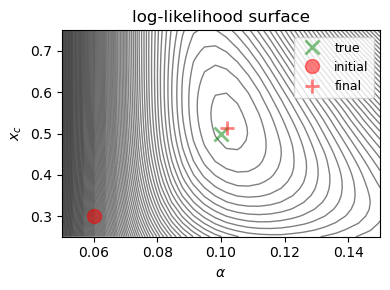

In [54]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.contour(αs, xcs,
           log_likelihood_surface.T,
           100,
           colors="k",
           linestyles="solid",
           linewidths=1, alpha=0.5,
           )
ax.plot(params_true[0], params_true[2], "gx", alpha=0.5, ms=10, mew=2, label="true")
ax.plot(params0[0], params0[2], "ro", alpha=0.5, ms=10, label="initial")
ax.plot(params[0], params[2], "r+", alpha=0.5, ms=10, mew=2, label="final")
ax.legend(loc="upper right", fontsize=9)
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel(r"$x_c$")
ax.set_title(r"log-likelihood surface")
plt.tight_layout()
plt.show()

Assess reconstruction accuracy

In [59]:
p_samples_inferred = p_solve(x, sampling_times, *params, Q)

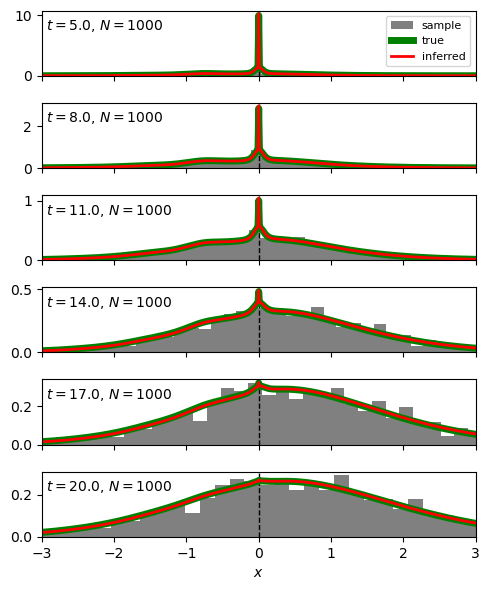

In [60]:
fig, axes = plt.subplots(n_samples, 1, figsize=(5, 6), sharex=True)
for sampling_time, sample, p_sample, p_sample_inferred, ax in zip(sampling_times, samples, p_samples.T, p_samples_inferred.T, axes):
    ax.axvline(0, color='k', ls='--', lw=1)
    ax.hist(x[sample], bins=50, density=True, color='grey',
            label="sample" if sampling_time == sampling_times[0] else None)
    ax.plot(x, p_sample / (x[1] - x[0]), lw=5, color='green',
            label="true" if sampling_time == sampling_times[0] else None)
    ax.plot(x, p_sample_inferred / (x[1] - x[0]), lw=2, color='r', alpha=1,
    label="inferred" if sampling_time == sampling_times[0] else None)
    ax.annotate(rf"$t={sampling_time}$, $N={sample_size}$", xy=(0.01, 0.7), xycoords="axes fraction")
ax.set_xlabel(r"$x$")
ax.set_xlim(x_min, x_max)
axes[0].legend(loc="upper right", fontsize=8)
plt.tight_layout()
plt.show()